# Question 1

1.1)

In [12]:
from numpy import array, zeros_like, concatenate, logspace, identity, sum, log as ln, empty, inf, inner, isnan
from numpy.random import randint, seed
from numpy.fft import fft
from numpy.linalg import cond, inv, norm
from scipy.linalg import toeplitz
from math import sqrt
from statistics import mean

N_u = 500
seed(30)
u = randint(0,2,size=N_u)

y = zeros_like(u, dtype='float64')
for n in range(2, N_u):
    y[n] = .4*y[n-1] - .6*y[n-2] + 2*u[n-1]

def my_var(x):
    N = len(x)
    u_x = sum(x)/N
    return sum((x-u_x)**2)/(N-1)

1.2)

In [13]:
# The first half of the generated signal
N = N_u // 2
AIC_p, BIC_p = empty(3), empty(3)
AIC_best, BIC_best = inf, inf
all_n, all_m = array((1, 2, 2)), array((1, 1, 2))
all_e = []

for i, (n, m) in enumerate(zip(all_n, all_m)):
    # transformation matrix -> [N-n x n+m]
    # OBS: Due to Python has a zero-based indexing, y[k-1]-> y(k)
    X = concatenate((toeplitz(y[n-1:N-1], y[:n][::-1]), toeplitz(u[n-1:N-1], u[n-m:n][::-1])), axis=1)
    # Tikhonov regularization
    for lambda_ in logspace(0,10,base=2):
        if cond(X.T@X + (lambda_-1)*identity(n+m)) < 1e3:
            # Ordinary Least-Square (OLS)
            theta_hat = inv(X.T@X + (lambda_-1)*identity(n+m))@X.T@y[n:N]
            break
    # estimated signal
    y_hat = X @ theta_hat
    # residue
    e = y[n:N] - y_hat
    all_e.append(e)
    N_e = e.size
    sigma2_e = my_var(e)
    p = m+n
    # Akaike’s Information criterion (AIC)
    AIC_p[i] = N_e*ln(sigma2_e) + 2*p
    if AIC_p[i] < AIC_best:
        AIC_best = AIC_p[i]
        iAIC_best = i # best iteration
    # Bayesian Information criterion (BIC)
    BIC_p[i] = N_e*ln(sigma2_e) + p*ln(N_e)
    if BIC_p[i] < BIC_best:
        BIC_best = BIC_p[i]
        iBIC_best = i # best iteration

print("Akaike's Information criterion (AIC):")
for i, (n, m) in enumerate(zip(all_n, all_m)):
    print(f'\tAIC({n},{m}) = {AIC_p[i]:.2e}')
print(f'\tThe best option for the AIC is {{n, m}}={{{all_n[iAIC_best]}, {all_m[iAIC_best]}}}\n\n')

print('Bayesian Information criterion (BIC):')
for i, (n, m) in enumerate(zip(all_n, all_m)):
    print(f'\tBIC({n},{m}) = {BIC_p[i]:.2e}')
print(f'\tThe best option for the BIC is {{n, m}}={{{all_n[iBIC_best]}, {all_m[iBIC_best]}}}')

Akaike's Information criterion (AIC):
	AIC(1,1) = -1.50e+02
	AIC(2,1) = -1.73e+04
	AIC(2,2) = -1.71e+04
	The best option for the AIC is {n, m}={2, 1}


Bayesian Information criterion (BIC):
	BIC(1,1) = -1.43e+02
	BIC(2,1) = -1.73e+04
	BIC(2,2) = -1.71e+04
	The best option for the BIC is {n, m}={2, 1}


1.3)

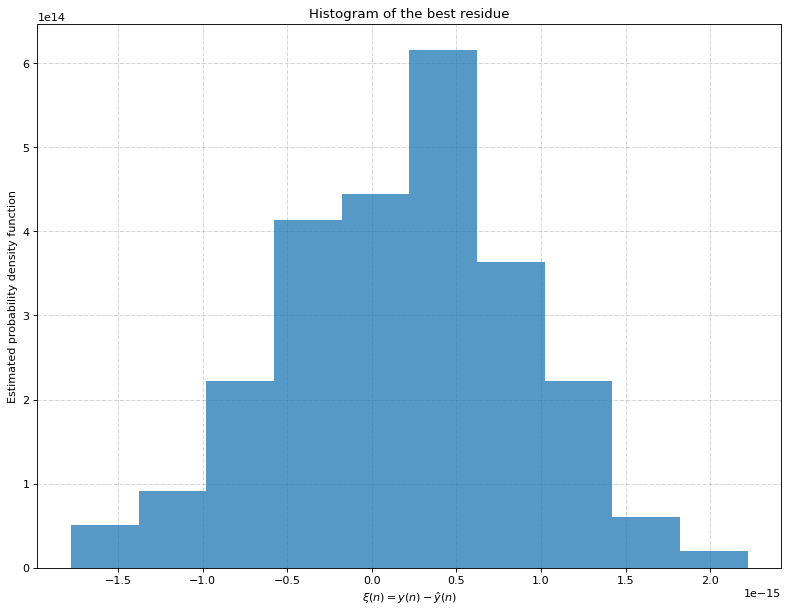

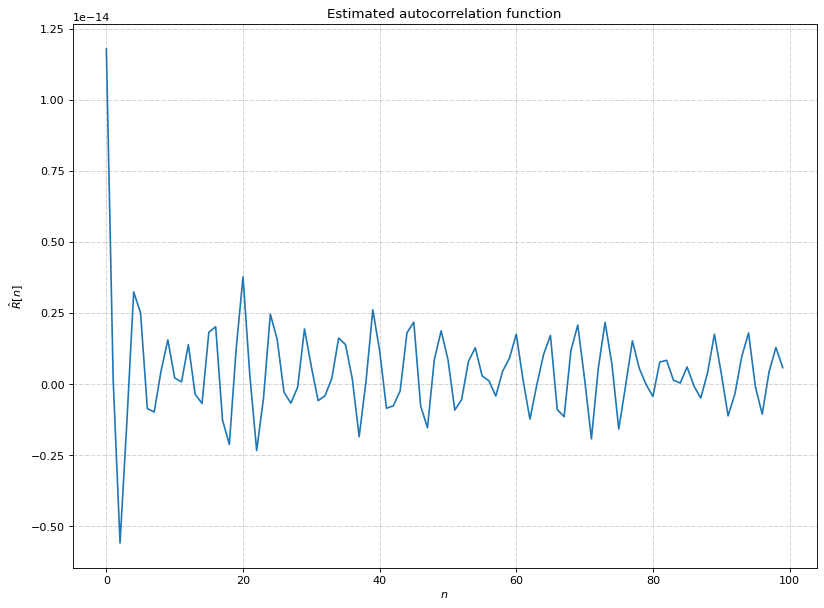

The root mean square error to the best AR(n,m) residue is:1.64e-08


In [14]:
from matplotlib import pyplot as plt

### histogram of the best residue
e_best = all_e[iAIC_best]
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.hist(e_best, bins=10, density=True, alpha=0.75)
plt.xlabel(r'$\xi(n) = y(n)-ŷ(n)$')
plt.ylabel('Estimated probability density function')
plt.title('Histogram of the best residue')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

### autocorrelation function
n_max = 100
# truncate the empty part
e_best = e_best[4:]
N_e = e_best.size
r = empty(n_max)
for n in range(n_max):
    r[n] = inner(e_best[:N_e-n], e_best[n:])/norm(e_best)

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(r)
plt.xlabel(r'$n$')
plt.ylabel(r'$\hat{R}\left[n\right]$')
plt.title('Estimated autocorrelation function')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

rmse_e = sqrt(mean(e))
print(f'The root mean square error to the best AR(n,m) residue is:{rmse_e:.2e}')


The $ARX(n,m)$ (autoregressive with exogenous inputs) model, with $n>m$ aims to represent a mathematically a  system whose output results from delayed versions of the input and output signals plus a random process. The output signal can be written by
\begin{align}
    A(q) y\left[ n \right] = B\left[ q \right] u\left[ k \right] + v \left[ k \right],
\end{align}
where $v \left[ k \right]$ is a random noise and
\begin{align}
    A(q) = 1 - a_1q^{-1} - a_2q^{-2} \dots - a_nq^{-n}
\end{align}
and
\begin{align}
    B(q) = b_1q^{-1} + b_2q^{-2} \dots + b_mq^{-m},
\end{align}
are polynomials with arbitrary coefficients $\left\{ a_i \right\}_{i=1}^{n}$ and $\left\{ b_i \right\}_{i=1}^{m}$, respectively, and $q^{-1}$ is the delay operator. Let us define the matricial notation of the ARX(n, m) model, given by
\begin{align}
    y\left[ k \right] & = a_1 y\left[ k-1 \right] + a_2 y\left[ k-2 \right] + \dots + a_n y\left[ k-n \right] + b_1 u\left[ k-1 \right] + b_2 u\left[ k-2 \right] + \dots + b_n u\left[ k-m \right] + v\left[ k \right] \\
    & = \pmb{\theta}^{\mathsf{T}} \pmb{\Psi}\left[ k-1 \right] + v\left[ k \right]
\end{align}
where
\begin{align}
    \pmb{\theta} & = \left[ a_0, a_1, \cdots, a_{n}, b_0, b_1, \cdots, b_{m} \right]^{\mathsf{T}} \in \mathbb{R}^{n+m}
\end{align}
is the parameter vector, and
\begin{align}
    \pmb{\Psi}& = \left[ y\left[k-1\right], y\left[k-2\right], \cdots, y\left[k-n\right], u\left[k-1\right], u\left[k-2\right], \cdots, u\left[k-m\right] \right]^\mathsf{T} \in \mathbb{R}^{n+m}
\end{align}
is the regressor vector.

The main goal of modeling a system using the ARX(n, m) is to
- Define the set $\left\{n, m\right\}$ that produces the best result with the shortest possible length of $n$ and $m$.
- Compute the coefficients, $\pmb{\theta}$.

Let $\hat{\pmb{\theta}}$ be the estimation of $\pmb{\theta}$, which is computed using some estimation technique. The signal $\hat{y} \left[n\right] = \hat{\pmb{\theta}}^{\mathsf{T}} \pmb{\Psi}\left[ k-1 \right]$ is the estimation of $y \left[n\right]$, and $\xi \left[n\right] = y \left[n\right] - \hat{y} \left[n\right]$ is the residual signal of this estimation, that is, the difference between the actual output and the ARX(n, m) model output.

The ordinary Least-Square (OLS) is a batch solution that aims to estimate $\pmb{\theta}$ using the following cost function:
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) = \sum_n^{N-1} \left( y \left[ n \right] - \hat{y}\left[ n \right] \right)^2 ,
\end{align}

where $N$ denotes the amount of the data available to prediction, and it shall be buffered before performing the OLS algorithm. Note that is not possible to use the whole data due to causality constrainments.

Although this method has no optimality properties associated with it, OLS is widely used in practice because of its ease of implementation, its reasonable performance, and the fact that it does not require any probabilistic assumptions about the data.Naturally, the main drawback is that no claims about the optimality of the OLS algorithm can be made. Another disadvantage is that this algorithm computes solely in offline fashion as it is needed a database of $N$ samples before estimating $\pmb{\theta}$.

The cost function can be rewritten in the matrix notation, given by
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) & = \left(\mathbf{y} - \hat{\mathbf{y}}\right)^\mathsf{T}\left(\mathbf{y} - \hat{\mathbf{y}}\right) \\
    & = \left(\mathbf{y} - \mathbf{H}\pmb{\theta}\right)^\mathsf{T}\left(\mathbf{y} - \mathbf{H}\pmb{\theta}\right)
\end{align}
where
